
# Árboles de Decisión — Banknote Authentication (UCI)

**Objetivos de la práctica**  
- Cargar el dataset  
- EDA  
- División *train/test* (70/30)  
- Entrenar un árbol de decisión  
- Comparar precisión en función de `max_depth`  
- Mostrar el árbol en **texto**  
- Visualizar **regiones de decisión** (con 2 *features*)  
- Construir **Matriz de Confusión** y métricas  
- Redactar una **interpretación final**


In [1]:

# 0) Imports y configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, precision_score,
    recall_score, f1_score
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['axes.grid'] = True



## 1) Cargar dataset y quedarnos con 2 *features*
Usaremos **variance** y **skewness** para poder dibujar regiones de decisión fácilmente.


In [2]:

# 1) Carga de datos
possible_paths = [
    'data_banknote_authentication.csv',
    '/kaggle/input/bank-note-authentication-uci-data/data_banknote_authentication.csv'
]

df = None
for p in possible_paths:
    try:
        df = pd.read_csv(p)
        break
    except Exception:
        pass

if df is None:
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
    cols = ['variance','skewness','curtosis','entropy','target']
    df = pd.read_csv(url, header=None, names=cols)

df.columns = [c.lower().strip() for c in df.columns]
if 'class' in df.columns and 'target' not in df.columns:
    df.rename(columns={'class':'target'}, inplace=True)

X = df[['variance','skewness']].values
y = df['target'].values

df.head()


,variance,skewness,curtosis,entropy,target
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0



## 2) EDA rápido
Comprobamos tamaños, valores nulos, balance de clases y estadísticas descriptivas.


Shape: (1372, 5)

Valores nulos por columna:
variance    0
skewness    0
curtosis    0
entropy     0
target      0
dtype: int64

Balance de clases (target):
target
0    762
1    610
Name: count, dtype: int64

Estadísticas descriptivas (variance & skewness)


,variance,skewness
count,1372.000000,1372.000000
mean,0.433735,1.922353
std,2.842763,5.869047
min,-7.042100,-13.773100
25%,-1.773000,-1.708200
50%,0.496180,2.319650
75%,2.821475,6.814625
max,6.824800,12.951600


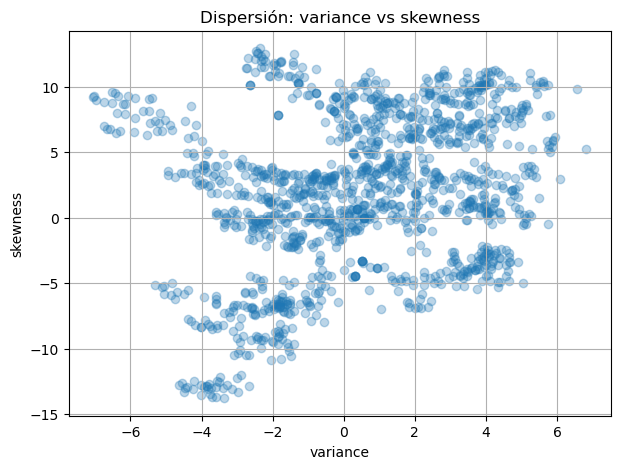

In [3]:

print("Shape:", df.shape)
print("\nValores nulos por columna:")
print(df.isna().sum())

print("\nBalance de clases (target):")
print(df['target'].value_counts())

print("\nEstadísticas descriptivas (variance & skewness)")
display(df[['variance','skewness']].describe())

plt.figure()
plt.scatter(df['variance'], df['skewness'], alpha=0.3)
plt.xlabel('variance'); plt.ylabel('skewness'); plt.title('Dispersión: variance vs skewness')
plt.show()



## 3) División en *train/test* (70/30, estratificado)


In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((960, 2), (412, 2))


## 4) Árbol de decisión — modelo base


In [5]:

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

y_pred_tr = tree.predict(X_train)
y_pred_te = tree.predict(X_test)

acc_tr = accuracy_score(y_train, y_pred_tr)
acc_te = accuracy_score(y_test, y_pred_te)

print(f"Accuracy (train): {acc_tr:.3f}")
print(f"Accuracy (test) : {acc_te:.3f}")


Accuracy (train): 1.000
Accuracy (test) : 0.930



## 5) Precisión según `max_depth`


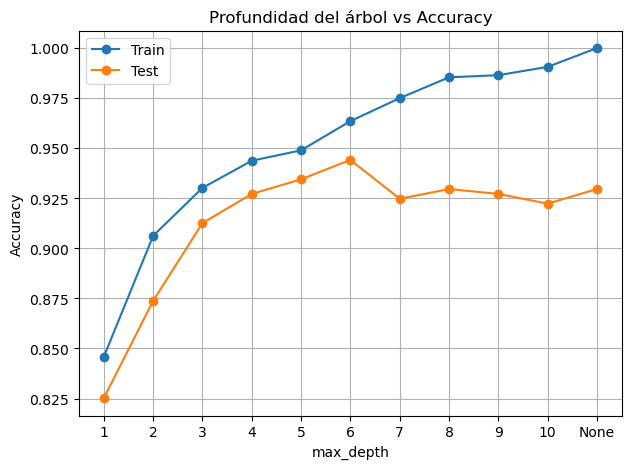

Mejor max_depth según test: 6 → Accuracy: 0.944


In [6]:

depths = [1,2,3,4,5,6,7,8,9,10,None]
train_scores, test_scores = [], []

for d in depths:
    clf = DecisionTreeClassifier(random_state=42, max_depth=d)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

x_labels = [str(d) if d is not None else 'None' for d in depths]

plt.figure()
plt.plot(range(len(depths)), train_scores, marker='o', label='Train')
plt.plot(range(len(depths)), test_scores, marker='o', label='Test')
plt.xticks(range(len(depths)), x_labels)
plt.xlabel('max_depth'); plt.ylabel('Accuracy')
plt.title('Profundidad del árbol vs Accuracy'); plt.legend(); plt.show()

best_idx = int(np.argmax(test_scores))
print("Mejor max_depth según test:", depths[best_idx], "→ Accuracy:", round(test_scores[best_idx],3))



## 6) Mostrar árbol en **texto**


In [7]:

best_depth = depths[best_idx]
best_tree = DecisionTreeClassifier(random_state=42, max_depth=best_depth)
best_tree.fit(X_train, y_train)

tree_text = export_text(best_tree, feature_names=['variance','skewness'])
print(tree_text)


|--- variance <= 0.77
|   |--- skewness <= 5.36
|   |   |--- variance <= 0.32
|   |   |   |--- variance <= -0.26
|   |   |   |   |--- variance <= -1.78
|   |   |   |   |   |--- skewness <= 1.77
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- skewness >  1.77
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- variance >  -1.78
|   |   |   |   |   |--- variance <= -1.77
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- variance >  -1.77
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- variance >  -0.26
|   |   |   |   |--- skewness <= -0.03
|   |   |   |   |   |--- variance <= -0.03
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- variance >  -0.03
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- skewness >  -0.03
|   |   |   |   |   |--- class: 1
|   |   |--- variance >  0.32
|   |   |   |--- skewness <= 3.22
|   |   |   |   |--- variance <= 0.74
|   |   |   |   |   |--- skewness <= -2.11
|   |   |   |   |   |   |--- clas


## 7) Regiones de decisión (2D)


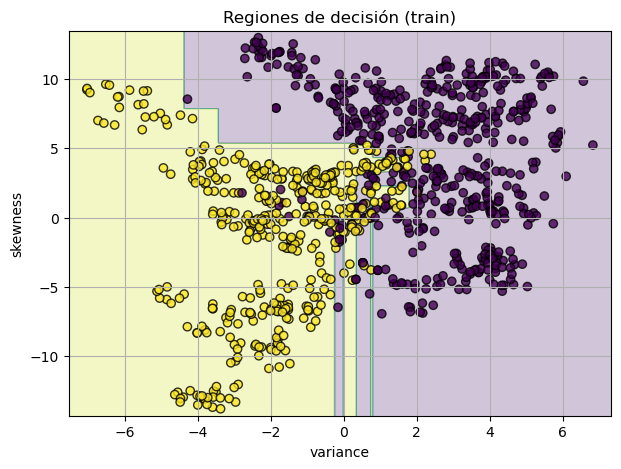

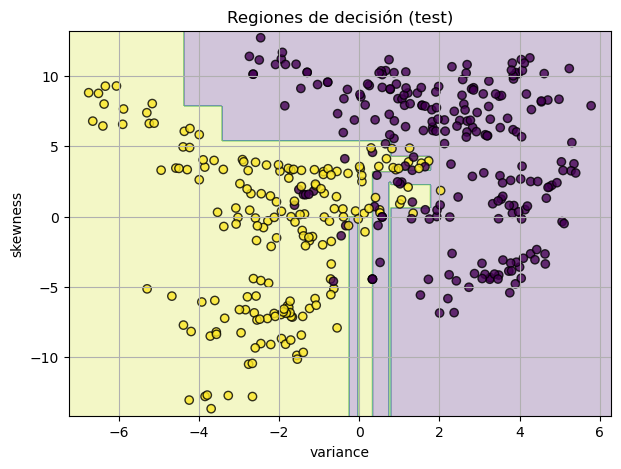

In [8]:

def plot_decision_regions_2d(model, X, y, title='Decision regions'):
    x_min, x_max = X[:, 0].min()-0.5, X[:, 0].max()+0.5
    y_min, y_max = X[:, 1].min()-0.5, X[:, 1].max()+0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k', alpha=0.8)
    plt.xlabel('variance'); plt.ylabel('skewness'); plt.title(title)
    plt.show()

plot_decision_regions_2d(best_tree, X_train, y_train, title='Regiones de decisión (train)')
plot_decision_regions_2d(best_tree, X_test, y_test, title='Regiones de decisión (test)')



## 8) Matriz de Confusión y métricas
Filas = **Predicción** (Positivo/Negativo) · Columnas = **Realidad** (Positivo/Negativo)


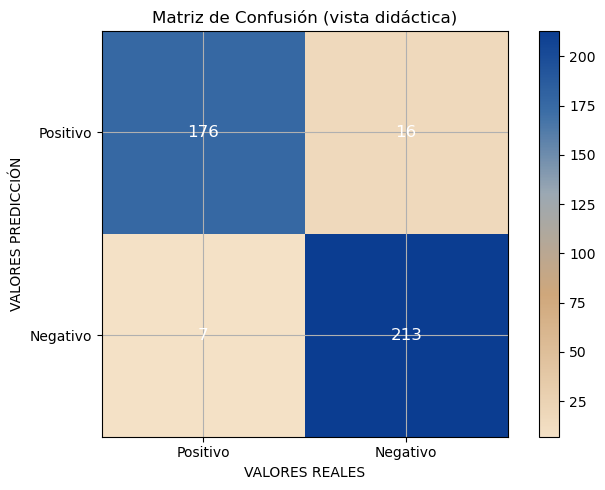

TP, TN, FP, FN = 176 213 16 7
Accuracy : 0.944
Precision: 0.917
Recall   : 0.962
F1-score : 0.939

Informe de clasificación:

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       229
           1       0.92      0.96      0.94       183

    accuracy                           0.94       412
   macro avg       0.94      0.95      0.94       412
weighted avg       0.95      0.94      0.94       412



In [9]:

y_pred_best = best_tree.predict(X_test)

cm_official = confusion_matrix(y_test, y_pred_best, labels=[1,0])
TP, FN, FP, TN = cm_official.ravel()

cm_view = np.array([[TP, FP],
                    [FN, TN]])

brown_to_blue = LinearSegmentedColormap.from_list(
    "brown_to_blue",
    [
        (0.00, "#F4E1C6"),
        (0.35, "#CFA77B"),
        (0.60, "#9BA8B3"),
        (0.80, "#3C6EA6"),
        (1.00, "#0B3D91"),
    ],
    N=256
)

fig, ax = plt.subplots()
im = ax.imshow(cm_view, cmap=brown_to_blue)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Positivo','Negativo'])
ax.set_yticklabels(['Positivo','Negativo'])
ax.set_xlabel('VALORES REALES'); ax.set_ylabel('VALORES PREDICCIÓN')
plt.colorbar(im, ax=ax)

for i in range(2):
    for j in range(2):
        ax.text(j, i, int(cm_view[i, j]), ha='center', va='center', color='white', fontsize=12)

plt.title('Matriz de Confusión (vista didáctica)')
plt.tight_layout(); plt.show()

acc  = accuracy_score(y_test, y_pred_best)
prec = precision_score(y_test, y_pred_best, zero_division=0)
rec  = recall_score(y_test, y_pred_best, zero_division=0)
f1   = f1_score(y_test, y_pred_best, zero_division=0)

print(f"TP, TN, FP, FN = {TP} {TN} {FP} {FN}")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print("\nInforme de clasificación:\n")
print(classification_report(y_test, y_pred_best, digits=2))



## 9) Interpretación final — guía
- ¿En qué `max_depth` se logra **mejor rendimiento en test**? ¿Aparecen señales de **sobreajuste** al aumentar la profundidad?  
- Observa la **matriz de confusión**: ¿qué tipo de error domina (FP o FN)? Relaciónalo con *precision* y *recall*.  
- Añade las otras observaciones que consideres importante
